# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

# Exploración de Datos

In [2]:
#Importo las librerias necesarias 

import gzip
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

# **Reviews**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 2
for l in parse('D:/Acamica/Clases Acamica/Sprint 3/Proyecto/steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

In [5]:
data_reviews.head()
data_reviews.shape

(3896535, 12)

In [6]:
data_reviews.isna().sum()

username              0
hours             13206
products           7531
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     3296831
compensation    3823747
user_id         2308752
dtype: int64

#### Selecciono las columnas que me resulten interesantes para el desarrollo de este Proyecto :

1. Descartar columnas poco informativas.
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
1. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

In [7]:
columnas_descartables = ['date','page','page_order','user_id','compensation','found_funny']
data_Rev = data_reviews.drop(columnas_descartables,1)

In [8]:
data_Rev.shape

(3896535, 6)

In [9]:
data_Rev.head(2)

,username,hours,products,product_id,text,early_access
0,Chaos Syren,0.1,41.0,725280,This would not be acceptable as an entertainme...,False
1,hello?<,14.6,2.0,328100,Better than Minecraft,False


Elimino los nulos en 'hours' y 'products', para poder convertir los valores a tipos de datos que ocupen menos espacio en memoria.

In [10]:
data_Rev.dropna(inplace = True)

data_Rev['hours'] = data_Rev['hours'].astype(np.float32)
data_Rev['products'] = data_Rev['products'].astype(np.uint32)
data_Rev['product_id'] = data_Rev['product_id'].astype(np.uint32)

gc.collect()

0

Guardo el dataset, ya que la carga del mismo es lenta.

In [11]:
data_Rev.isnull().sum()

username        0
hours           0
products        0
product_id      0
text            0
early_access    0
dtype: int64

In [12]:
if True:
    data_Rev.to_csv(r'D:/Acamica/Clases Acamica/Sprint 3/Proyecto/Datos_1_prueba.csv', index= False)

# **Games**

In [4]:
data_games = []
for l in parse('D:/Acamica/Clases Acamica/Sprint 3/Proyecto/steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [5]:
data_games.shape

(32135, 16)

In [26]:
data_games[data_games.id == '274190']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
4551,Devolver Digital,"[Action, Adventure, Casual, Indie]",Broforce,Broforce,http://store.steampowered.com/app/274190/Brofo...,2015-10-15,"[America, Action, Pixel Graphics, Co-op, 2D, P...",NaN,http://steamcommunity.com/app/274190/reviews/?...,"[Single-player, Multi-player, Co-op, Shared/Sp...",14.99,False,274190,Free Lives,Overwhelmingly Positive,83


In [27]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [28]:
columnas_descartables = ['tags','title','specs','developer','price','discount_price','metascore','reviews_url','early_access','release_date','url','publisher','sentiment']
data_Gam = data_games.drop(columnas_descartables,1)

In [29]:
data_Gam.head(2)

,genres,app_name,id
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,761140
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,643980


In [30]:
data_Gam.id.dtype

dtype('O')

In [31]:
#Convierto la columna 'id' a enteros 
data_Gam = data_Gam[data_Gam['id'].notna()]
data_Gam['id'] = data_Gam['id'].astype(np.uint32)
#Pongo la columna 'id' como indice para luego utilizar .loc[]
data_Gam.set_index(['id'],inplace = True)
data_Gam.head()

,genres,app_name
id,,
761140,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty
643980,"[Free to Play, Indie, RPG, Strategy]",Ironbound
670290,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians
767400,"[Action, Adventure, Casual]",弹炸人2222
773570,NaN,Log Challenge


In [32]:
#Guardo
if True:
    data_Gam.to_csv(r'D:/Acamica/Clases Acamica/Sprint 3/Proyecto/Datos_2_Games.csv', index= True)   

#### Realizare algunos gráficos para implementar una calificación. Debo responder algunas preguntas para usar de guía:
   1. ¿Cuáles son los juegos más populares?
   1. ¿Cuáles son los usuarios con más horas jugadas?
   1. ¿Cuáles son los juegos más utilizados por los usuarios?
   1. ¿Cuántos usuarios probaron más de un juego?
   1. ¿Qué mediana y media tienen las horas de juego?
   1. ¿Qué juegos tienen early access?¿y cuáles son los tiempos jugados medios? 

In [3]:
#Cargo nuevamente el dataset de Reviews
data_Rev = pd.read_csv(r'D:/Acamica/Clases Acamica/Sprint 3/Proyecto/Datos_1_prueba.csv')

In [4]:
data_Rev.head(2)

,username,hours,products,product_id,text,early_access
0,Chaos Syren,0.1,41,725280,This would not be acceptable as an entertainme...,False
1,hello?<,14.6,2,328100,Better than Minecraft,False


In [14]:
#Cargo nuevamente el dataset de Games
data_Gam = pd.read_csv(r'D:/Acamica/Clases Acamica/Sprint 3/Proyecto/Datos_2_Games.csv',index_col = 'id')

In [15]:
data_Gam.head(2)

,genres,app_name,tags,specs,developer
id,,,,,
761140,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],Kotoshiro
670290,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult...",Poolians.com


### **1.**

In [16]:
#Considero a los juegos más populares los que más veces se reiteran en 'product_id'
df_user = pd.DataFrame(np.c_[data_Rev.product_id.value_counts(),data_Rev.product_id.value_counts().index],columns = ['review','product_id'],dtype='int32')
print('Los 10 Juegos más populares: \n')
df_user = df_user[:10].copy()
df_user[['game','genres']] = data_Gam[['app_name','genres']].loc[df_user.product_id].values
df_user

Los 10 Juegos más populares: 



KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([377160, 271590, 391540, 301520], dtype='int64', name='id'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

### **2.**

In [7]:
grouped = data_Rev.groupby('username')
time_user = pd.DataFrame(grouped['hours'].agg(np.sum))

In [8]:
print('Usuarios con más y menos horas de juego')
df_time = time_user.sort_values(by='hours',ascending=False)
df_time['username']= df_time.index
df_time = df_time.reset_index(drop=True)
df_time


Usuarios con más y menos horas de juego


,hours,username
0,553184.1,123
1,73682.5,947183 / Terrix - Hourboost.com
2,65646.3,SLAPY
3,65423.4,Tuong
4,59227.4,Ayase | FF15 HYPE
...,...,...
1309818,0.0,THEYUBBS
1309819,0.0,n0vyn0vyn0vyn0vygod
1309820,0.0,BigBrandonBear
1309821,0.0,Stormagettion


Observo que tengo usuarios que han calificado juegos y no los han jugado.

In [9]:
#Elimino los usuarios que no han jugado 
mask = data_Rev.hours != 0
data_Rev = data_Rev[mask]

### **3.**

In [10]:
groupe = data_Rev.groupby('product_id')
time_game = pd.DataFrame(groupe['hours'].agg(np.sum))

In [13]:
print('Juegos con más horas')
df_game = time_game.sort_values(by='hours',ascending=False)
df_game['product_id']= df_game.index
df_game = df_game.reset_index(drop=True)
df_game = df_game[:10].copy()
df_game[['game','genres']] = data_Gam[['app_name','genres']].loc[df_game.product_id].values
df_game

Juegos con más horas


,hours,product_id,game,genres
0,44845013.0,440,Team Fortress 2,"['Action', 'Free to Play']"
1,14573417.7,252490,Rust,"['Action', 'Adventure', 'Indie', 'Massively Mu..."
2,10996795.3,230410,Warframe,"['Action', 'Free to Play']"
3,9075150.2,4000,Garry's Mod,"['Indie', 'Simulation']"
4,8505421.4,107410,Arma 3,"['Action', 'Simulation', 'Strategy']"
5,7516176.9,346110,ARK: Survival Evolved,"['Action', 'Adventure', 'Indie', 'Massively Mu..."
6,5356419.2,377160,Fallout 4,['RPG']
7,4953280.6,48700,Mount & Blade: Warband,"['Action', 'RPG']"
8,4518933.6,240,Counter-Strike: Source,['Action']
9,4390058.6,221100,DayZ,"['Action', 'Indie', 'Massively Multiplayer', '..."


### **4.**

In [26]:
print('El porcentaje de usuarios que probaron más de un juegos es:')
print(((len(data_Rev.username)-len(data_Rev.username.unique()))*100)/len(data_Rev.username),'%')

El porcentaje de usuarios que probaron más de un juegos es:
55.92023871108399 %


Un porcentaje muy bajo lo cual nos puede traer el problema de arranque en frio en el sistema de recomendación.

Un grafico pairplot es una buena muestra de la distribucion de variables.

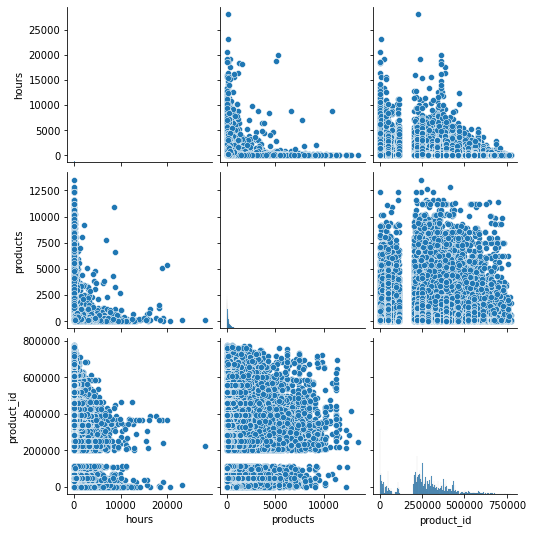

In [10]:
sns.pairplot(data_Rev)

- Observo con claridad que los usuarios con más de 1000 productos tienen menos de 2000hs jugadas y los usuarios con grandes cantidades de horas jugadas tienen menos cantidad de productos.
- Mas alto el 'product_id', menos jugadores tiene.
- Existen usuarios con tiempos de juego muy altos.
 

In [17]:
#Hago una copia para el analisis
dato = data_Rev.copy()

In [18]:
data_Rev.shape

(3875815, 6)

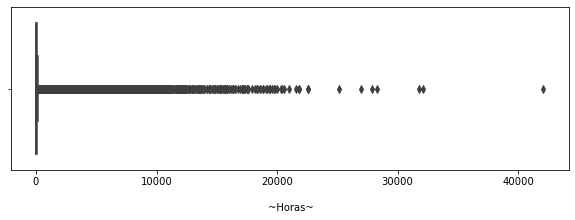

In [37]:
plt.figure(figsize=(10,3))
sns.boxplot(data = dato, x = 'hours')          
plt.xlabel('\n ~Horas~') 
plt.show()

Vemos como ciertos valores generan outliers, aplico la regla de las Tres sigmas.


In [38]:
#defino una funcion que aplica la regla de las Tres Simas
def remove_outliers_TS(df, column_name, sigma):
    valor_medio = df[column_name].mean()
    std = df[column_name].std()
    minimo = valor_medio - sigma*std
    maximo = valor_medio + sigma*std
    mascara_outliers = np.logical_or(df[column_name] < minimo, df[column_name] > maximo)
    print('Datos eliminados:')
    print(mascara_outliers.sum() / len(mascara_outliers) * 100,'%')
    df = df[~mascara_outliers]
    return df

In [39]:
dato = remove_outliers_TS(dato,'hours',3)

Datos eliminados:
1.6154675373151666 %


Al aplicar la regla de las tres sigmas estoy omitiendo el 1.61% de datos, los outliers de varias horas jugadas me interesan así que solo los omito en este análisis. Voy a implementar una calificación que dependerá de las horas que el usuario utilizo el juego.

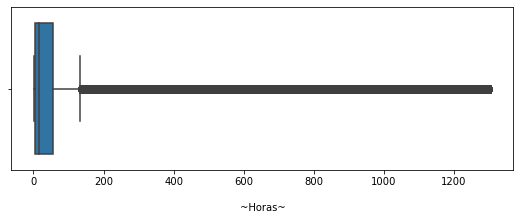

In [40]:
plt.figure(figsize=(9,3))
sns.boxplot(data = dato, x = 'hours')          
plt.xlabel('\n ~Horas~') 
plt.show()

### **5.**

In [41]:
print('Mediana de horas con filtrado: ',dato.hours.median())
print('Mediana de horas sin filtrado: ',data_Rev.hours.median())
print('Media de horas con filtrado: ',dato.hours.mean())
print('Media de horas sin filtrado: ',data_Rev.hours.mean())
print('Varianza de horas con filtrado: ',dato.hours.std())
print('Varianza de horas sin filtrado: ',data_Rev.hours.std())

Mediana de horas con filtrado:  14.8
Mediana de horas sin filtrado:  15.4
Media de horas con filtrado:  73.68798874403502
Media de horas sin filtrado:  112.21756848535354
Varianza de horas con filtrado:  165.88020983700844
Varianza de horas sin filtrado:  396.94743267288516


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'hours'),
  Text(0, 1.5, 'products'),
  Text(0, 2.5, 'product_id'),
  Text(0, 3.5, 'early_access')])

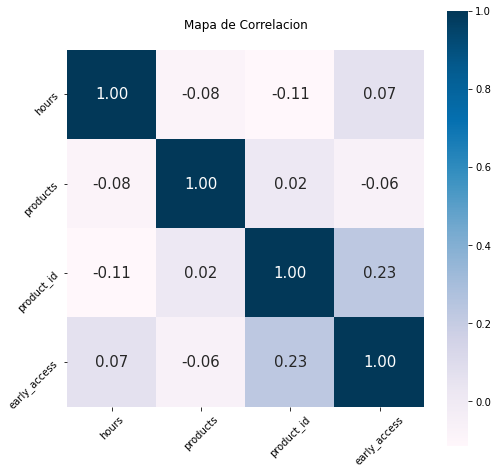

In [42]:
corr = dato.corr()
corr

plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
             xticklabels= corr.columns.values, 
             yticklabels= corr.columns.values, cmap= 'PuBu')
plt.title('Mapa de Correlacion\n')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)

No hay gran correlacion entre los variables, la mayor correlacion es entre 'early_access' y 'product_id'

### **6.**

In [47]:
dat = data_Rev[data_Rev.early_access == True]
#dat = dat.hours.sort_values(ascending=False)
print('la mediana con early_access',dat.hours.median())
print('la media con early_access',dat.hours.mean())
#dat.head(5)

la mediana con early_access 24.9
la media con early_access 142.62892574703508


Evaluo los comentarios de algunos juegos con mas de 4hs y menos de 70hs jugadas, considero que es una zona importante por los valores de media y mediana obtenidos.

In [19]:
mask = np.logical_and(dato.hours < 70 ,dato.hours > 4)
dato = dato[mask]

In [20]:
dato.head(15)

,username,hours,products,product_id,text,early_access
1,hello?<,14.600000,2,328100,Better than Minecraft,False
2,DarklyThinking,16.600000,577,35140,Still worth playing in 2018.\nProbably my favo...,False
5,Ariman1,13.200000,1386,328100,Addictive RPG ! Works fine on linux though it ...,False
7,Coby,8.900000,227,35140,Finished the game around 6 hours. Thats only t...,False
8,The Undead StalkeR,17.000000,87,35140,9/10\nEven after all these years. this game re...,False
12,tredain,8.400000,182,35600,Cute game with a decent length and some real b...,False
13,9kfreemen,6.500000,1147,328100,"Well, I'm about 4 hours into the game, but I t...",False
15,The_Cpt_FROGGY,7.800000,2217,631920,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False
16,Mono,14.100000,54,506510,A Charming game with colourful pixel graphics ...,False
18,Kodyd194,5.000000,181,431320,"Recourse Demo, overall it seemed pretty beefy ...",False


In [5]:
data_Rev = data_Rev.drop(['products','early_access','text'],1)

### Pretendo implementar un sistema de calificación  que asigne:

    1 - si el usuario jugo menos de 5hs.
    2 - si el usuario jugo entre 5hs y 15hs.
    3 - si el usuario jugo entre 15hs y 60hs. 
    4 - si el usuario jugo más de 60hs.
    
Donde **1** representaría la puntuación más baja, es decir, al usuario no le agrado el juego y **4** la puntuación más elevada donde supones que al usuario le encanto el juego.

In [6]:
mask1 = data_Rev.hours < 5
califi1 = mask1.map({False:0,True:1})

mask2 = np.logical_and(data_Rev.hours < 15,data_Rev.hours >=5)
califi2 = mask2.map({False:0,True:2})

mask3 = np.logical_and(data_Rev.hours < 60,data_Rev.hours >=15)
califi3 = mask3.map({False:0,True:3})

mask4 = data_Rev.hours >= 60
califi4 = mask4.map({False:0,True:4})

califi0 = califi1 + califi2 + califi3 + califi4
califi0.head(10)

0    1
1    2
2    3
3    1
4    1
5    2
6    1
7    2
8    3
9    1
Name: hours, dtype: int64

In [7]:
data_Rev['hours'] = califi0.astype(np.uint8)

In [8]:
data_Rev.rename(columns={'hours':'calification'}, inplace=True) 
data_Rev.head(2)

,username,calification,product_id
0,Chaos Syren,1,725280
1,hello?<,2,328100


Al tener el dataset preparado, lo guardamos para utilizarlo mas rápidamente.

In [9]:
if True:
    data_Rev.to_csv(r'D:/Acamica/Clases Acamica/Sprint 3/Proyecto/Datos_2_Review.csv', index= False)

# Filtro Colaborativo

#### Dataset y Train/test split

In [53]:
reader = Reader()

In [54]:
N_filas = 1500000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(data_Rev[['username', 'product_id', 'calification']][:N_filas], reader)

In [55]:
trainset, testset = train_test_split(data, test_size=.25)

#### Entrenamiento

Comienzo con un modelo por default SVD, para utilizarlo de benchmark.

In [56]:
algo = SVD()

In [57]:
algo.fit(trainset)

In [58]:
predictions = algo.test(testset)

# Evaluación

#### Metrica a Utilizar

La métrica con la que evaluare el modelo de regresión es la raíz del error cuadrado promedio (RMSE), es sensible a valores atípicos al igual que el error cuadrado promedio (MSE), puedo trabajar con las mismas unidades y magnitudes que la variable, no así con el MSE al estar elevado al cuadrado. 

A menor valor de RMSE, mejor es el regresor. En el caso ideal, los errores serán 0.

In [59]:
accuracy.rmse(predictions)

RMSE: 0.8743


0.874261198243332

#### Optimización de Hiperparametros

In [150]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [ 1, 2, 4, 8, 16, 32, 64]

for i in factores:
    print('\nRMSE con factor', i,'en el SVD\n')
    algo = SVD(n_factors = i)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 4, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


RMSE con factor 1 en el SVD

Evaluating RMSE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    0.8869  0.8835  0.8855  0.8856  0.8854  0.0012  
Fit time          8.74    8.60    9.53    8.50    8.84    0.41    
Test time         1.97    1.13    1.54    1.02    1.41    0.37    

RMSE con factor 2 en el SVD

Evaluating RMSE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    0.8863  0.8831  0.8842  0.8874  0.8853  0.0017  
Fit time          9.13    9.15    9.89    8.89    9.27    0.37    
Test time         1.56    0.99    1.62    1.03    1.30    0.29    

RMSE con factor 4 en el SVD

Evaluating RMSE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    0.8847  0.8869  0.8865  0.8834  0.8854  0.0014  
Fit time          9.73    9.43    9.88    8.91    9.49    0.37    
Test time         1.05    

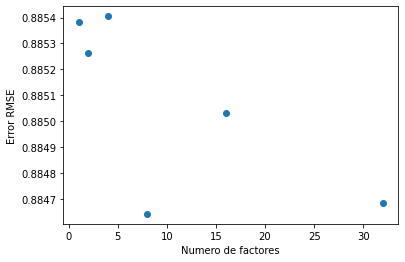

In [151]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

Aplico GridSearchCV para buscar valores óptimos, lo realizo con 3 validaciones cruzadas por que demora bastante tiempo. 

In [152]:
param_grid = {'n_factors': [4,8,15,16],'n_epochs': [15,18,20,23], 'lr_all': [0.002,0.05,0.010,0.1],
              'reg_all': [0.01,0.02,0.002,0.4]}
gs = GridSearchCV(SVD, param_grid = param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [153]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8830308087155213
{'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.02}


Vuelvo a entrenar un SVD con los hiperparametros optimizados.

In [154]:
algo_opt = SVD(n_factors=15, n_epochs=20, lr_all=0.01,reg_all=0.02)
algo_opt.fit(trainset)

In [155]:
pred = algo_opt.test(testset)

In [156]:
accuracy.rmse(pred)

RMSE: 0.8834


0.8833510771970097

#### Obtuvimos una leve mejora en el resultado.

Probemos si es razonable el resultado viendo que le recomendaria a un usuario

In [22]:
usuario = 'Nick'
calification = 2   # le pedimos peliculas a las que haya puesto 2 o mas puntos
df_user = data_Rev[(data_Rev['username'] == usuario) & (data_Rev['calification'] >= calification)]
df_user = df_user.reset_index(drop=True)
df_user[['game','genre']] = data_Gam[['app_name','genres']].loc[df_user.product_id].values
print('Calificaciones de',usuario)
df_user.head() 
#len(df_user.product_id)

Calificaciones de Nick


,username,calification,product_id,game,genre
0,Nick,3,214560,Mark of the Ninja,"['Action', 'Adventure', 'Indie']"
1,Nick,3,350280,LawBreakers,['Action']
2,Nick,3,17430,Need for Speed Undercover,"['Action', 'Racing']"
3,Nick,2,359900,The Incredible Adventures of Van Helsing III,"['Action', 'Adventure', 'Indie', 'RPG']"
4,Nick,4,47890,The Sims™ 3,['Simulation']


In [33]:
#Cargo la lista de juegos 
recomendaciones_usuario = data_Gam.iloc[:len(data_Gam)].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()


(32133, 2)


,genres,app_name
id,,
761140,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty
643980,"[Free to Play, Indie, RPG, Strategy]",Ironbound
670290,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians
767400,"[Action, Adventure, Casual]",弹炸人2222
773570,NaN,Log Challenge


In [34]:
#Juegos que probo el usuario
usuario_review = data_Rev[data_Rev['username'] == usuario]
print('Juegos que probo')
print(usuario_review.shape)
usuario_review = usuario_review.reset_index(drop=True)
usuario_review.head()

Juegos que probo
(477, 3)


,username,calification,product_id
0,Nick,3,214560
1,Nick,3,350280
2,Nick,1,230050
3,Nick,1,245150
4,Nick,3,17430


In [35]:
#Elimino los juegos que probo para que no se repitan 
recomendaciones_usuario.drop(usuario_review.product_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.shape

(31758, 3)

In [36]:
recomendaciones_usuario.head(1)

,id,genres,app_name
0,761140,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty


In [42]:
#Realizo las predicciones 
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['id'].apply(
                                            lambda x: algo_opt.predict(usuario, x).est)

NameError: name 'algo' is not defined

In [41]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(15)

KeyError: 'Estimate_Score'

In [43]:
df_user = df_user.sort_values('calification',ascending = False)
df_user.head(15)

,username,calification,product_id,game,genre
65,Nick,4,4000,Garry's Mod,"['Indie', 'Simulation']"
10,Nick,4,271590,Grand Theft Auto V,"['Action', 'Adventure']"
37,Nick,4,224820,Super House of Dead Ninjas,"['Action', 'Indie']"
21,Nick,4,9900,Star Trek Online,"['Free to Play', 'Massively Multiplayer', 'RPG']"
147,Nick,4,3900,Sid Meier's Civilization® IV,['Strategy']
274,Nick,4,201230,EverQuest® II Free-To-Play. Your Way.™,"['Free to Play', 'Massively Multiplayer', 'RPG']"
281,Nick,4,236870,HITMAN™,['Action']
276,Nick,4,49520,Borderlands 2,"['Action', 'RPG']"
15,Nick,4,271590,Grand Theft Auto V,"['Action', 'Adventure']"
117,Nick,4,8980,Borderlands,"['Action', 'RPG']"


Evaluando los juegos y los generos que el usuario probó, los resultados parecen razonables, el sístema de recomendacion le muestra juegos de acción, RPG, simulación y estrategia.

### Investigación

Este Sístema de Recomendación es simple pero a la vez funcional, para su desarrolo continuaria:

- Realizando una mejora en la forma de otorgar valor a la calificación con variables que esten correlacionadas y pueda lograr plasmarlo en los valores, así lograr algo más sólido que solo el uso horario del juego.
- Aumentando la cantidad de datos procesados, por que al momento de probarlo con 2597690 reviews solo el 49.29% de los usuarios realizaron una review del juego, lo que me genera el problema de arranque en frío.
- Una opción al tener 2597690 y el 49.29% de usuarios con mas de un review es eliminar los que solo tuvieron un acercamiento con los review.
- Expandiendo el análisis con la implementación de un metodo hibrido entre un filtro colaborativo y un filtro basado en contenido, donde en algunos analisis se ha demostrado ser mejor que el filtro colaborativo solo (https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/notebook).
